# Exercise Session 7 – Multi Regional Input Output (MRIO) Analysis
### ENV–501 Material and Energy Flow Analysis

November 3rd, 2022

Exercises developed for Jupyter Notebook by Matteo Barsanti



### Estimate the Economy wide MFA of your NUTS 2 with EXIOBASE 3 and pymrio 

Run an EW-MFA with pymrio for NUTS 2, which you selected for your project. 
You can use the results as a term of comparison with those calculated by adopting a bottom-up approach or to fill the gap in case some voices cannot be retrived. 

#### Templetate for Switzerland

In [1]:
# -- Import the required libraries 

import pymrio 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# -- Import the data (it takes 2/3 minutes)

exio3 = pymrio.parse_exiobase3(path=r'IOT_2020_ixi.zip')

In [3]:
# -- Grouping the satellite accounts/ stressors - B
# You can aggregate the stressor to calculate environmental impacts etc..

groups = exio3.satellite.get_index(as_dict=True, grouping_pattern = {'.': 'Other',
                                                                     'Domestic Extraction Used*.': 'Material Used',
                                                                     'Unused*.': 'Material Unused'})
groups

{'Taxes less subsidies on products purchased: Total': 'Other',
 'Other net taxes on production': 'Other',
 "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled": 'Other',
 "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled": 'Other',
 "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled": 'Other',
 'Operating surplus: Consumption of fixed capital': 'Other',
 'Operating surplus: Rents on land': 'Other',
 'Operating surplus: Royalties on resources': 'Other',
 'Operating surplus: Remaining net operating surplus': 'Other',
 'Employment: Low-skilled male': 'Other',
 'Employment: Low-skilled female': 'Other',
 'Employment: Medium-skilled male': 'Other',
 'Employment: Medium-skilled female': 'Other',
 'Employment: High-skilled male': 'Other',
 'Employment: High-skilled female': 'Other',
 'Employment hours: Low-skilled male': 'Other',
 'Employment hours: Low-skilled female

In [4]:
# -- Aggreagated the stressor based on the selected grouping patterns

# copy the stressors
exio3.satellite_agg = exio3.satellite.copy(new_name='Aggregated material accounts')

# aggregate the stressors
for df_name, df in zip(exio3.satellite_agg.get_DataFrame(data=False, with_unit=True, with_population=False),
                       exio3.satellite_agg.get_DataFrame(data=True, with_unit=True, with_population=False)):
    if df_name == 'unit':
        exio3.satellite_agg.__dict__[df_name] = df.groupby(groups).apply(lambda x: ' & '.join(x.unit.unique()))
    else:
        exio3.satellite_agg.__dict__[df_name] = df.groupby(groups).sum()
        
# show the aggregated stressors
exio3.satellite_agg.F

region                                 AT                       \
sector          Cultivation of paddy rice Cultivation of wheat   
Material Unused                         0         4.249328e+02   
Material Used                           0         1.416866e+03   
Other                                   0         2.802598e+08   

region                                            \
sector          Cultivation of cereal grains nec   
Material Unused                     1.485668e+03   
Material Used                       3.311079e+03   
Other                               2.946147e+08   

region                                                  \
sector          Cultivation of vegetables, fruit, nuts   
Material Unused                           2.671500e+03   
Material Used                             2.465183e+03   
Other                                     1.201958e+08   

region                                    \
sector          Cultivation of oil seeds   
Material Unused             4.066019e+02   
Material Used               4.877252e+02   
Other                       6.924441e+07   

region                                                 \
sector          Cultivation of sugar cane, sugar beet   
Material Unused                          1.668320e+03   
Material Used                            3.336639e+03   
Other                                    1.860913e+07   

region                                                                      \
sector          Cultivation of plant-based fibers Cultivation of crops nec   
Material Unused                          0.617124             1.529187e+01   
Material Used                            3.085619             7.684823e+01   
Other                                82863.640439             1.953349e+06   

region                                        ...                       WM  \
sector          Cattle farming  Pigs farming  ... Landfill of waste: Paper   
Material Unused   1.688369e+03  6.063231e+01  ...             4.578261e+02   
Material Used     1.088063e+04  1.954392e+02  ...             5.795739e+02   
Other             2.690014e+08  7.940599e+07  ...             2.012360e+09   

region                                      \
sector          Landfill of waste: Plastic   
Material Unused               5.760648e+01   
Material Used                 8.848872e+01   
Other                         1.089857e+08   

region                                                    \
sector          Landfill of waste: Inert/metal/hazardous   
Material Unused                             1.455949e+02   
Material Used                               1.702147e+02   
Other                                       5.537861e+07   

region                                                               \
sector          Landfill of waste: Textiles Landfill of waste: Wood   
Material Unused                8.274985e+01            1.088896e+02   
Material Used                  1.294332e+02            1.602728e+02   
Other                          3.183875e+08            1.174853e+08   

region                                                             \
sector          Activities of membership organisation n.e.c. (91)   
Material Unused                                      1.083202e+00   
Material Used                                        7.223160e+00   
Other                                                3.146418e+08   

region                                                               \
sector          Recreational, cultural and sporting activities (92)   
Material Unused                                       4.614032e+01    
Material Used                                         6.565385e+01    
Other                                                 5.575800e+08    

region                                         \
sector          Other service activities (93)   
Material Unused                  2.013208e-04   
Material Used                    6.818335e-04   
Other                            4.155809e

In [5]:
# -- Show the aggregated stressor unites

exio3.satellite_agg.unit

Material Unused                                                   kt
Material Used                                                     kt
Other              M.EUR & 1000 p & M.hr & kg & kg CO2-eq & km2 &...
dtype: object

In [6]:
# -- Update to system for a new final demand

# rescaling factor basd on population
# western Switzerland: population 2.1 million; whole Switzerland: population 8.7 million 
pop_ratio = 2.1 / 8.7

# Copy the final demand into a new final demoand vector
Y_new = exio3.Y.copy()

# show the targeted elements of Y
list_cols = ['Final consumption expenditure by households',
             'Final consumption expenditure by non-profit organisations serving households (NPISH)',
             'Final consumption expenditure by government',
             'Gross fixed capital formation',
            ]

# Update Y to consider only for wester Switzerland  
Y_new.loc['CH',('CH',list_cols)] = (Y_new.loc['CH',('CH',list_cols)] * pop_ratio).values
Y_new.loc['CH',('CH',list_cols)] 


region                                                                                      CH  \
category                                           Final consumption expenditure by households   
sector                                                                                           
Cultivation of paddy rice                                                             0.000000   
Cultivation of wheat                                                                  0.030759   
Cultivation of cereal grains nec                                                      0.018639   
Cultivation of vegetables, fruit, nuts                                                0.140671   
Cultivation of oil seeds                                                              0.563496   
...                                                                                        ...   
Activities of membership organisation n.e.c. (91)                                     9.196634   
Recreational, cultural and sporting activities ...                                  407.771579   
Other service activities (93)                                                       786.315362   
Private households with employed persons (95)                                        66.028289   
Extra-territorial organizations and bodies                                            0.000000   

region                                                                                                                                   \
category                                           Final consumption expenditure by non-profit organisations serving households (NPISH)   
sector                                                                                                                                    
Cultivation of paddy rice                                                                    0.000000                                     
Cultivation of wheat                                                                         0.038440                                     
Cultivation of cereal grains nec                                                             0.023293                                     
Cultivation of vegetables, fruit, nuts                                                       0.175801                                     
Cultivation of oil seeds                                                                     0.008317                                     
...                                                                                               ...                                     
Activities of membership organisation n.e.c. (91)                                         1755.131364                                     
Recreational, cultural and sporting activities ...                                        1742.856031                                     
Other service activities (93)                                                                0.860137                                     
Private households with employed persons (95)                                                0.163870                                     
Extra-territorial organizations and bodies                                                   0.000000                                     

region                                                                                          \
category                                           Final consumption expenditure by government   
sector                                                                                           
Cultivation of paddy rice                                                             0.000000   
Cultivation of wheat                                                                  0.102030   
Cultivation of cereal grains nec                                                      0.061826   
Cultivation of vegetables, fruit, nuts                                                0.4666

In [7]:
# -- Diagonalized the stressors and run the calculation with the updated Y vector
# each loop of the for cycle takes 2/3 minutes

#  copy the original IOSystem
exio3_new = exio3.copy()

# assign the new final demand 
exio3_new.Y = Y_new

# dictionary for storing the results
exiobase3_new_res = {k:0 for k in ['DE','UDE','IMP','EXP']}

for i in ['Material Used', 'Material Unused']:
    res_diag   = exio3.satellite_agg.diag_stressor((i), name = 'res_diag')

    # set the stressor diagonal
    exio3_new.res_diag = res_diag
    
    # perform all the calculation
    exio3_new.calc_all()
    
    # store results 
    if i == 'Material Used':
        exiobase3_new_res['DE'] = exio3_new.res_diag.D_cba_reg.CH.CH.sum() 
        exiobase3_new_res['IMP'] += exio3_new.res_diag.D_imp_reg.CH.sum() 
        exiobase3_new_res['EXP'] += exio3_new.res_diag.D_exp_reg.CH.sum() 
    else:
        exiobase3_new_res['UDE'] = exio3_new.res_diag.D_cba_reg.CH.CH.sum() 


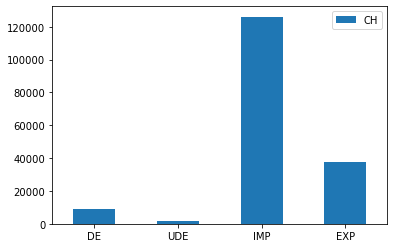

In [8]:
# -- Plot the results

results = pd.DataFrame.from_dict(exiobase3_new_res, orient='index',
                                 columns=['CH'])

ax = results.plot.bar(rot=0)